# Trajectory simplification

In this notebook:
<ol>
    <li> Introduction
        <ol>
        <li> Problem Characterization
        <li> Strategy & Algorithms Overview
        </ol>
    <li> Naive sampling methods
        <ol>
        <li>Random sampling + evaluation
        <li>Uniform sampling + evaluation
        <li>Minimum displacement heuristic
        <li> Speed heuristic + evaluation
        <li>Naive sampling methods compare and constrast
        </ol>
    <li> Filters
        <ol>
        <li>Mean filter
        <li>Median filter
        <li>Kalman (??)
        </ol> 
    <li> Algorithms
        <ol>
        <li>RDP
        <li>Imai-Iri
        <li>...
        </ol>
    <li> Evaluation
        <ol>
        <li>Error
        <li>Computation
        </ol>
    <li> ...
</ol>

In [2]:
# Third party imports
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import shapely as shp
from datetime import datetime

# local imports
import add_geometry_points as agp
import add_geometry_lines as agl

In [3]:
# Open the file as a pd.DataFrame
df = pd.read_csv("C:/Users/anape/Downloads/outsight/resources/0109-traj.csv")

# Drop unnecessary columns
df.drop('zones',axis=1, inplace=True)
df.drop('z',axis=1, inplace=True)
df.drop('volume_m3',axis=1, inplace=True)

# Create a geodataframe with LineStrings from the original full data
gdf = agl.add_geometry(df)

## 1. Introduction

### 1.1. Problem Characterization

#### (1) Online vs Batch processing
This notebook focuses solely on batch processing methods (due to ease of implementation), which are inefficient in terms of memory storage. Given the expected volume of data, the memory issue of prime importance.


A current stretch goal (or a side quest, if you will) is to implement online trajectory simplification, which would greatly improve memory usage and would simplify the data pre-processing. While all samplings and filters can be easily adapted for online processing, the algorithms discussed in 3 require the full trajectory to be known.

#### (2) Trajectories
Most are relatively straight and simple, with no loops or backtracking. Some, however, are messy. These are unlikely to be vehicles, so they may not be central to the current project. However, it is important to consider them too, if future work focuses on pedestrians.

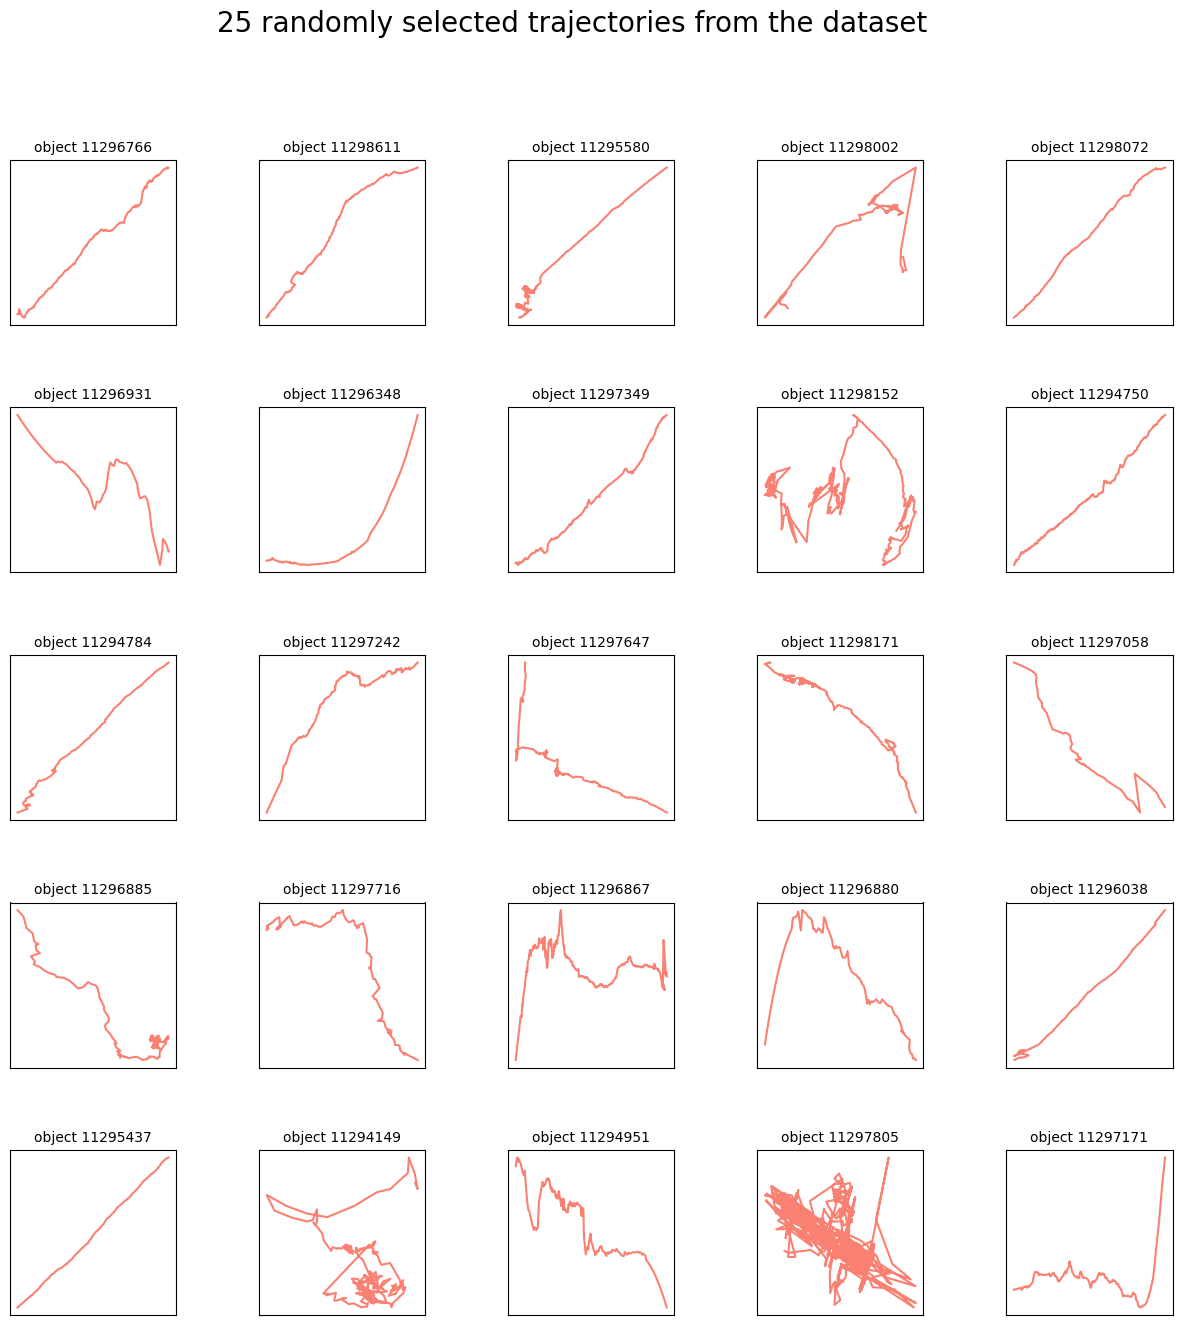

In [280]:
rows = 5
cols = 5
t_list = (df['object_id'].sample(n=rows*cols, random_state=42).tolist())
t_count = 0
fig, all_axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))

for r in range(rows):
    axes = all_axes[r]
    for c in range(cols):
        t = t_list[t_count]
        ax = axes[c]
        x, y = gdf.at[t, 'geometry'].xy
        ax.plot(x,y,color='salmon')
        ax.set_yticks(())
        ax.set_xticks(())
        ax.set_title(f'object {t}', fontsize=10)  

        t_count += 1
plt.subplots_adjust(hspace = 0.5, wspace = 0.5) 

fig.suptitle(f'{rows*cols} randomly selected trajectories from the dataset', fontsize=20)
plt.show()

The main issue is incompleteness as many trajectories (due to sensor imperfection, most likely) end abrubtly.

#### (3) Noise
Uncertainties arise from (1) sensor imprecision and (2) the processing of object recognition. Both error sources are largely unknown in terms of their occurrence frequency, distribution, etc.

Filters assume noise can be modeled with a zero-mean Gaussian distribution.

#### (4) Temporal aspect
Trajectories, as timeseries data, introduce a time-based dimension. This temporal aspect is important for the following consideration:

1. **Irregular data frequency and consistency:** Challenges emerge when data points are infrequent or have significant temporal and spatial gaps. Given the steady cadence of data collection (the LiDAR captures snapshots at a constant 20 f/s rate), this is unlikely to pose a problem for our specific use case.

2. **Determining similarity:** Trajectory similarity (as opposed to lines) is not limited to spatial characteristics alone. However, the present notebook prioritizes spatial over temporal similarity as the (current long-term) goal is to cluster trajectories based on geometric path.

Typically, time is incorporated as an additional dimension when dealing with trajectories. However, given the reasoning above, I'll temporarily set aside the temporal aspect.

#### (5) Performance measures
The following methods are evaluated based on 3 measures, as per Lee & Krumm.
1. **Processing time**: the execution time spent to run a trajectory data reduction algorithm;
2. **Compression rate**: the ratio in the size of an approximate trajectory vs. the size of its original trajectory;
3. **Error measure**: the deviation of an approximate trajectory from its original trajectory. As discussed in **(4) Temporal aspect**, we ignore the temporal dimension and use the traditional Euclidean distance as a measure of deviation. As discussed in **(2) Trajectories**, the trajectories are relatively simple and the Hausdorff distance is a good measure of similarity between the original and the reduced trajectory. The Frechet distance is most definitely an overkill, both conceptually and computationally.

### 1.2. Strategy & Algorithms Overview

The following sampling and filtering methods vary in complexity, both conceptually and computationally. The simplest ones, random & uniform sampling, are the cheapest computationally. However, there is a trade-off between simplicity and accuracy. The purpose of this notebook is to explore this trade-off. Simply put, the question of interest is: **"Should we bother using sophisticated methods or just stick with cheap-and-easy solutions?"**

The methods are tested against a sample dataset.

In [281]:
from describe_csv import df_info

# zones = gpd.read_file("C:/Users/anape/Downloads/outsight/resources/QGIS/lanes_and_int.geojson")
df_info("C:/Users/anape/Downloads/outsight/resources/0109-traj.csv")


FILE OVERVIEW 
 --- 
 START: 2023-01-09 10:01:04.904848 
 END: 2023-01-09 10:08:14.941481 
 TIMEDELTA: 0 days 00:07:10.036633 
 FRAMES: 8590 
 F/S: 20.0 
 

OBJECT CLASSES OVERVIEW 
 --- 
 TRACKED OBJECTS: 2260 
 DETECTED CLASSES: ['UNKNOWN' 'TWO_WHEELER' 'CAR' 'PERSON' 'TRUCK'] 
 
 CONSISTENT OBJECTS: 1142 
 --- 
 class
CAR              11
PERSON            3
TRUCK             1
TWO_WHEELER       2
UNKNOWN        1125 
 
 RECOGNIZED OBJECTS: 1035 
 --- 
 class
CAR            676
PERSON         264
TRUCK           13
TWO_WHEELER     82 
 
 UNIDENTIFIED OBJECTS: 83 
 



c:\Users\anape\Downloads\outsight\alb_output\geodata\describe_csv.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rec_df.drop(rec_df.loc[rec_df['object_id'].isin(a)].index, inplace=True)


In [282]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379927 entries, 0 to 379926
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   frame_number  379927 non-null  int64  
 1   timestamp     379927 non-null  object 
 2   object_id     379927 non-null  int64  
 3   class         379927 non-null  object 
 4   class_id      379927 non-null  int64  
 5   speed_kmh     379927 non-null  float64
 6   x             379927 non-null  float64
 7   y             379927 non-null  float64
dtypes: float64(3), int64(3), object(2)
memory usage: 23.2+ MB


## 2. Naive sampling methods

The cheap-and-easy solutions.

In [4]:
# for running empirical analyses
trials = 100

### 2.1. Random sampling (ratio)

Similar to online reservoir sampling. To account for the different sizes of trajectories, the volume of the reservoir is not fixed but a ratio n calculated based on the number of original data points per trajectory.

In [284]:
%%time

# Example with n=0.5
random_sampled_df = df.groupby("object_id", group_keys=False).apply(lambda group: group.sample(frac=0.5))
random_sampled_df = random_sampled_df.reset_index(drop=True) 
random_sampled_gdf = agl.add_geometry(random_sampled_df)


CPU times: total: 3.08 s
Wall time: 3.34 s


In order to find the best compression given this method, we'll try different ratios for the sampling and evaluate the runtime, compression and error (defined as the Hausdorff distance).

In [285]:
errors = []
runtimes = []
compressions = []

for n in np.arange(0.1,1,0.1):
    # Runtime
    curr_runtimes = []
    for k in range(0,trials): # Running this multiple times in order to accurately estimate runtimes
        start = datetime.now()
        random_sampled_df = df.groupby("object_id", group_keys=False).apply(lambda group: group.sample(frac=n))
        random_sampled_df = random_sampled_df.reset_index(drop=True) 
        end = datetime.now()
        curr_runtimes.append((end-start).total_seconds())
    runtimes.append(sum(curr_runtimes)/len(curr_runtimes)) # Taking the mean
    
    # Errors
    random_sampled_gdf = agl.add_geometry(random_sampled_df)
    hausforff_dist_results = []
    for index in random_sampled_gdf.index:
        original = gdf.at[index, 'geometry']
        sampled = random_sampled_gdf.at[index, 'geometry']
        hausforff_dist_results.append(shp.hausdorff_distance(original,sampled,densify = 0.9))
    errors.append(hausforff_dist_results)

    # Compression
    compressions.append(random_sampled_df.memory_usage(deep=True).sum()/df.memory_usage(deep=True).sum())

c:\Users\anape\Downloads\outsight\venv\Lib\site-packages\shapely\measurement.py:226: RuntimeWarning: invalid value encountered in hausdorff_distance_densify
  return lib.hausdorff_distance_densify(a, b, densify, **kwargs)
c:\Users\anape\Downloads\outsight\venv\Lib\site-packages\shapely\measurement.py:226: RuntimeWarning: invalid value encountered in hausdorff_distance_densify
  return lib.hausdorff_distance_densify(a, b, densify, **kwargs)
c:\Users\anape\Downloads\outsight\venv\Lib\site-packages\shapely\measurement.py:226: RuntimeWarning: invalid value encountered in hausdorff_distance_densify
  return lib.hausdorff_distance_densify(a, b, densify, **kwargs)
c:\Users\anape\Downloads\outsight\venv\Lib\site-packages\shapely\measurement.py:226: RuntimeWarning: invalid value encountered in hausdorff_distance_densify
  return lib.hausdorff_distance_densify(a, b, densify, **kwargs)
c:\Users\anape\Downloads\outsight\venv\Lib\site-packages\shapely\measurement.py:226: RuntimeWarning: invalid val

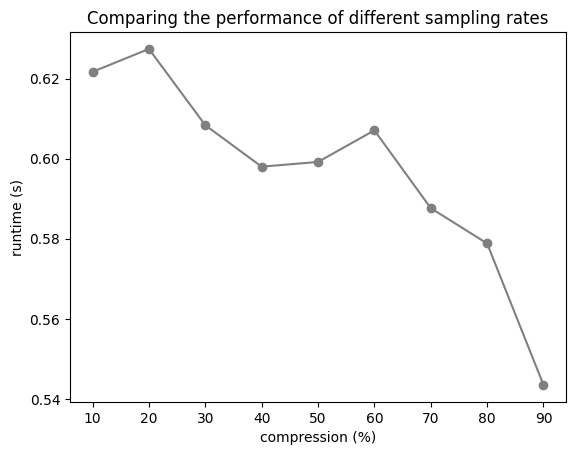

In [286]:
fig, ax = plt.subplots()
ax.plot([100-round(compression,3)*100 for compression in compressions],runtimes, marker='o', color='gray')
ax.set_xlabel('compression (%)')
ax.set_ylabel('runtime (s)')
ax.set_title('Comparing the performance of different sampling rates')
plt.show()

Compression and runtimes are negatively corelated. This might make sense as handling less datapoints (greater compression) is expected to take less time.

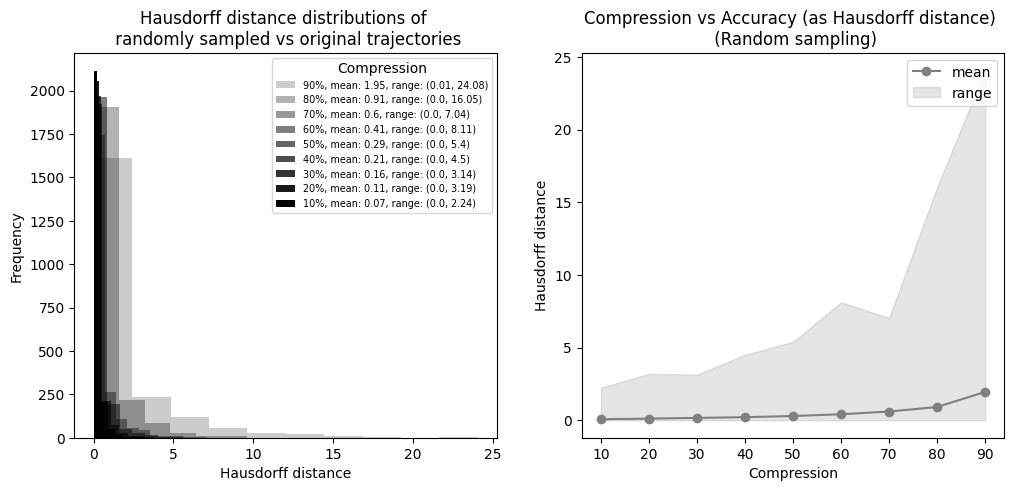

In [287]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Adjust the figsize as needed

mins = []
maxs = []
means = []

ax = axes[0]
for i, j in zip(errors, np.arange(0.1,1,0.1)):
    ax.hist(i,alpha=j+0.1,color='black',label=f'{round((1-j)*100)}%, mean: {round(sum(i)/len(i), 2)}, range: ({round(min(i),2)}, {round(max(i),2)})')

    mins.append(round(min(i),2))
    maxs.append(round(max(i),2))
    means.append(round(sum(i)/len(i), 2))
ax.set_ylabel('Frequency')
ax.set_xlabel('Hausdorff distance')
ax.legend(title='Compression',fontsize='x-small')
ax.set_title('Hausdorff distance distributions of \n randomly sampled vs original trajectories')

ax = axes[1]
x = [100-round(compression,3)*100 for compression in compressions]
ax.plot(x, means, marker='o', color='gray', label='mean')

# ax.plot(x, mins, marker='_', color='gray', linestyle='dashed')
# ax.plot(x, maxs, marker='_', color='gray', linestyle='dashed')
ax.fill_between(x, maxs, color='gray', alpha=0.2, label='range')
ax.legend()
ax.set_ylabel('Hausdorff distance')
ax.set_xlabel('Compression')
ax.set_title('Compression vs Accuracy (as Hausdorff distance) \n (Random sampling)')

plt.show()

It feels intuitive that the Hausdorff distance increases as the compression increases (sampling rate decreases). Before deciding what is a reasonable Hausdorff distance, a visual representation might help.

Upon closer inspection, there is something weird going on with the random sampling.

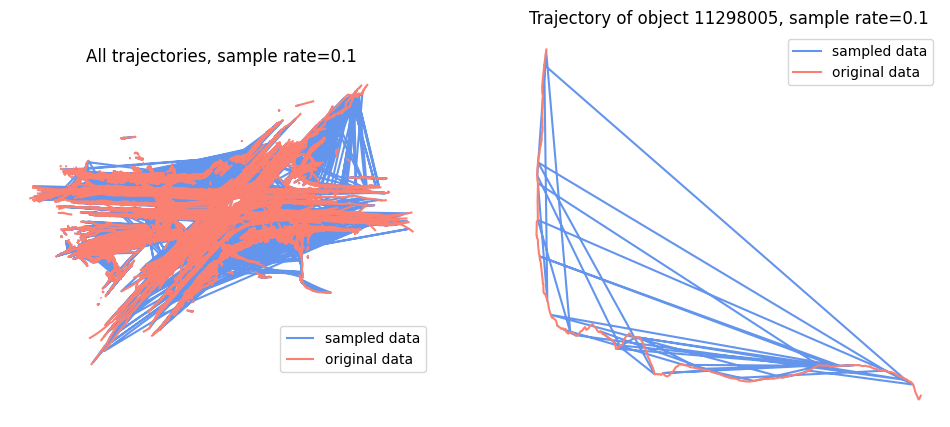

In [288]:
random_sampled_df = df.groupby("object_id", group_keys=False).apply(lambda group: group.sample(frac=0.1))
random_sampled_df = random_sampled_df.reset_index(drop=True) 
random_sampled_gdf = agl.add_geometry(random_sampled_df)

t = 11298005

x,y = gdf.at[t, 'geometry'].xy
x1, y1 = random_sampled_gdf.at[t, 'geometry'].xy

fig, axes = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1]})
ax = axes[0]
random_sampled_gdf.plot(ax=ax, color='cornflowerblue',label='sampled data')
gdf.plot(ax=ax, color='salmon', label='original data')
ax.legend(loc='lower right')
ax.set_title('All trajectories, sample rate=0.1')
ax.axis('off')


ax = axes[1]
ax.plot(x1,y1,color='cornflowerblue',label='sampled data')
ax.plot(x,y,color='salmon', label='original data')
ax.legend()
ax.set_title(f'Trajectory of object {t}, sample rate=0.1')
ax.axis('off')

plt.show()

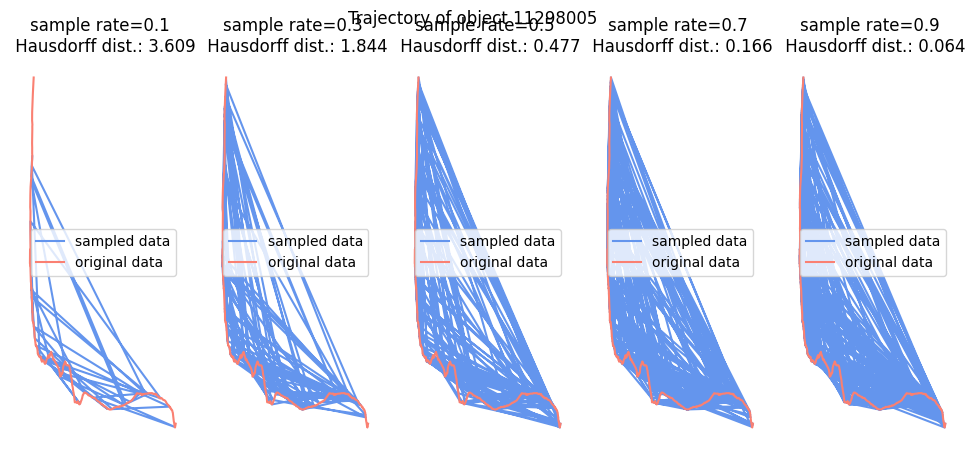

In [289]:
t = 11298005
x, y = gdf.at[t, 'geometry'].xy
fig, axes = plt.subplots(1, 5, figsize=(12, 5))

for n, i in zip(np.arange(0.1,1,0.2), np.arange(0,5,1)):

    random_sampled_df = df.groupby("object_id", group_keys=False).apply(lambda group: group.sample(frac=n))
    random_sampled_df = random_sampled_df.reset_index(drop=True) 
    random_sampled_gdf = agl.add_geometry(random_sampled_df)

    x1, y1 = random_sampled_gdf.at[t, 'geometry'].xy
    h = shp.hausdorff_distance(random_sampled_gdf.at[t, 'geometry'], gdf.at[t, 'geometry'])
    ax = axes[i]
    ax.plot(x1,y1,color='cornflowerblue',label='sampled data')
    ax.plot(x,y,color='salmon', label='original data')
    ax.legend()
    ax.set_title(f'sample rate={round(n,1)} \n Hausdorff dist.: {round(h,3)}')
    ax.axis('off')
fig.suptitle(f'Trajectory of object {t}')
plt.show()

It seems that random sampling does not preserve the order of points, which is essential when working with timeseries data.

An easy workaround this issue would be random sampling rows to drop (rather than keep), which I call "reverse sampling". The result looks much more reasonable:

In [290]:
def rev_random(df,n): # n is the desired sample, i.e. n=0.05 if we want the end result to be 5% of the original
    new_dfs = []
    n = 1 - n
    for _, group in df.groupby('object_id'):        
        sampled_group = group.sample(frac=n)
        group = group.drop(sampled_group.index)
        new_dfs.append(group)
    
    # Concatenate the modified groups into a new DataFrame
    new_df = pd.concat(new_dfs, ignore_index=True)
    
    return new_df

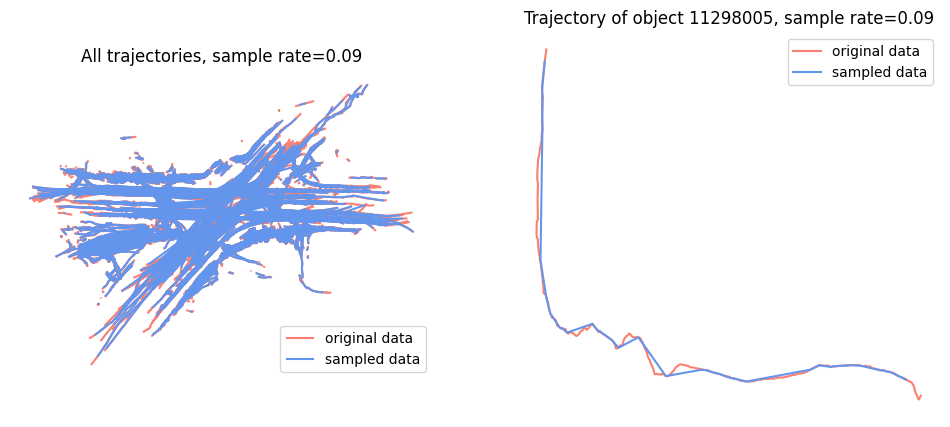

In [291]:
m = 0.09 # 95% compression
rev_random_sampled_df = rev_random(df, m)
rev_random_sampled_df = rev_random_sampled_df.reset_index(drop=True) 
rev_random_sampled_gdf = agl.add_geometry(rev_random_sampled_df)

t = 11298005

x,y = gdf.at[t, 'geometry'].xy
x1, y1 = rev_random_sampled_gdf.at[t, 'geometry'].xy

fig, axes = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1]})
ax = axes[0]
gdf.plot(ax=ax, color='salmon', label='original data')
rev_random_sampled_gdf.plot(ax=ax, color='cornflowerblue',label='sampled data')
ax.legend(loc='lower right')
ax.set_title(f'All trajectories, sample rate={m}')
ax.axis('off')


ax = axes[1]
ax.plot(x,y,color='salmon', label='original data')
ax.plot(x1,y1,color='cornflowerblue',label='sampled data')

ax.legend()
ax.set_title(f'Trajectory of object {t}, sample rate={m}')
ax.axis('off')

plt.show()

In [292]:
errors_rev_rand = []
runtimes_rev_rand = []
compressions_rev_rand = []

for n in np.arange(0.1,1,0.1):
    # Runtime
    curr_runtimes = []
    for k in range(0,trials): # Running this multiple times in order to accurately estimate runtimes
        start = datetime.now()
        random_sampled_df = rev_random(df, n)
        random_sampled_df = random_sampled_df.reset_index(drop=True) 
        end = datetime.now()
        curr_runtimes.append((end-start).total_seconds())
    runtimes_rev_rand.append(sum(curr_runtimes)/len(curr_runtimes)) # Taking the mean
    
    # Errors
    random_sampled_gdf = agl.add_geometry(random_sampled_df)
    hausforff_dist_results = []
    for index in random_sampled_gdf.index:
        original = gdf.at[index, 'geometry']
        sampled = random_sampled_gdf.at[index, 'geometry']
        hausforff_dist_results.append(shp.hausdorff_distance(original,sampled,densify = 0.9))
    errors_rev_rand.append(hausforff_dist_results)

    # Compression
    compressions_rev_rand.append(random_sampled_df.memory_usage(deep=True).sum()/df.memory_usage(deep=True).sum())

c:\Users\anape\Downloads\outsight\venv\Lib\site-packages\shapely\measurement.py:226: RuntimeWarning: invalid value encountered in hausdorff_distance_densify
  return lib.hausdorff_distance_densify(a, b, densify, **kwargs)
c:\Users\anape\Downloads\outsight\venv\Lib\site-packages\shapely\measurement.py:226: RuntimeWarning: invalid value encountered in hausdorff_distance_densify
  return lib.hausdorff_distance_densify(a, b, densify, **kwargs)
c:\Users\anape\Downloads\outsight\venv\Lib\site-packages\shapely\measurement.py:226: RuntimeWarning: invalid value encountered in hausdorff_distance_densify
  return lib.hausdorff_distance_densify(a, b, densify, **kwargs)
c:\Users\anape\Downloads\outsight\venv\Lib\site-packages\shapely\measurement.py:226: RuntimeWarning: invalid value encountered in hausdorff_distance_densify
  return lib.hausdorff_distance_densify(a, b, densify, **kwargs)
c:\Users\anape\Downloads\outsight\venv\Lib\site-packages\shapely\measurement.py:226: RuntimeWarning: invalid val

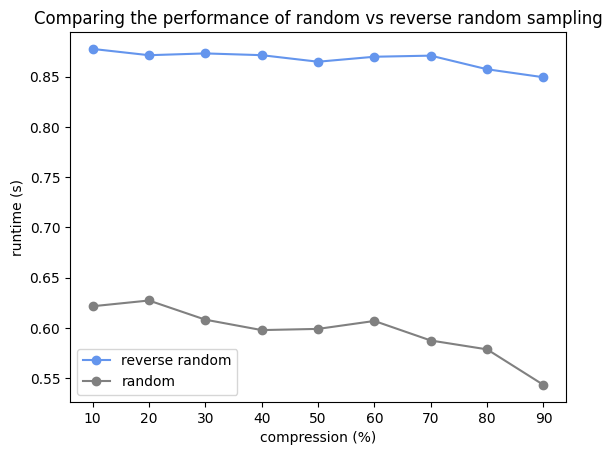

In [293]:
fig, ax = plt.subplots()
ax.plot([100-round(compression,3)*100 for compression in compressions_rev_rand],runtimes_rev_rand, marker='o', color='cornflowerblue', label='reverse random')
ax.plot([100-round(compression,3)*100 for compression in compressions],runtimes, marker='o', color='gray', label='random')
ax.set_xlabel('compression (%)')
ax.set_ylabel('runtime (s)')
ax.set_title('Comparing the performance of random vs reverse random sampling')
plt.legend()
plt.show()

As expected, this "reversal" increases runtime as it samples more points and then deletes them (more samples to pick & one additional operation). So, runtime is up, let's look at errors.

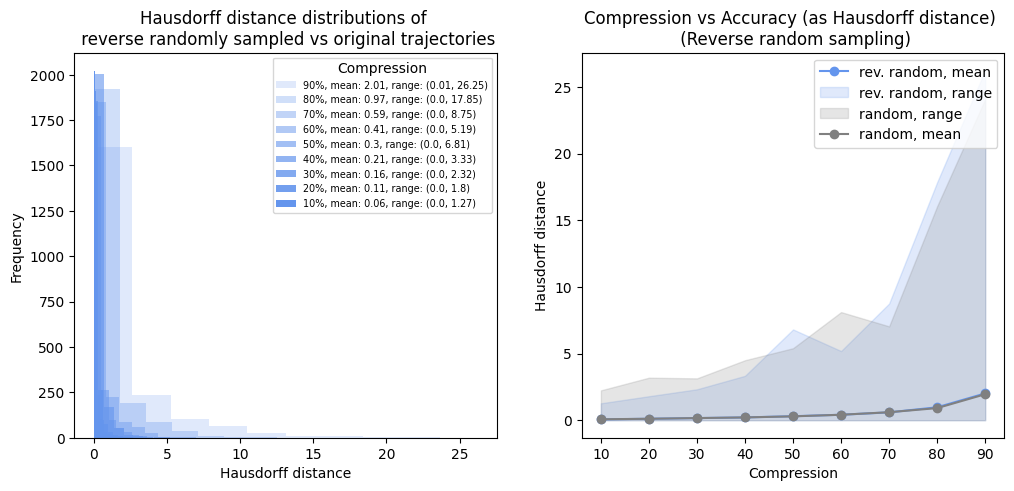

In [294]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Adjust the figsize as needed

mins_rev_rand = []
maxs_rev_rand = []
means_rev_rand = []

ax = axes[0]
for i, j in zip(errors_rev_rand, np.arange(0.1,1,0.1)):
    ax.hist(i,alpha=j+0.1,color='cornflowerblue',label=f'{round((1-j)*100)}%, mean: {round(sum(i)/len(i), 2)}, range: ({round(min(i),2)}, {round(max(i),2)})')

    mins_rev_rand.append(round(min(i),2))
    maxs_rev_rand.append(round(max(i),2))
    means_rev_rand.append(round(sum(i)/len(i), 2))
    
ax.set_ylabel('Frequency')
ax.set_xlabel('Hausdorff distance')
ax.legend(title='Compression',fontsize='x-small')
ax.set_title('Hausdorff distance distributions of \n reverse randomly sampled vs original trajectories')

ax = axes[1]
x = [100-round(compression,3)*100 for compression in compressions_rev_rand]
ax.plot(x, means_rev_rand, marker='o', color='cornflowerblue', label='rev. random, mean')
ax.fill_between(x, maxs_rev_rand, color='cornflowerblue', alpha=0.2, label='rev. random, range')

ax.fill_between(x, maxs, color='gray', alpha=0.2, label='random, range')
ax.plot(x, means, marker='o', color='gray', label='random, mean')


ax.legend()
ax.set_ylabel('Hausdorff distance')
ax.set_xlabel('Compression')
ax.set_title('Compression vs Accuracy (as Hausdorff distance) \n (Reverse random sampling)')

plt.show()

Something weird is happening (again!) - it seems there is no difference between random and reverse random sampling when it comes to errors.

While the trajectory visualizations from above suggest that reverse random sampling would be much better, the Hausdorff distance (unlike the Frechet distance) calculates the distance between sets of points, and **sets are unordered**. That is, the difference between random and reverse random sampling is the order in which we store the sampled points, but the Hausdorff calculation never even takes that into account.

So, besides for visualizing purposes, it does not make sense to use this so-called reverse random sampling.

### 2.2. Uniform sampling

Taking every i-th point (i=5 for a ~20% sample or ~80% compression). 

In [4]:
%%time 

def uniform_sample(group, i):
    return group.iloc[::i]

uniform_sampled_df = df.groupby("object_id", group_keys=False).apply(uniform_sample,i=25)
uniform_sampled_df = uniform_sampled_df.reset_index(drop=True)

uniform_sampled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16242 entries, 0 to 16241
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   frame_number  16242 non-null  int64  
 1   timestamp     16242 non-null  object 
 2   object_id     16242 non-null  int64  
 3   class         16242 non-null  object 
 4   class_id      16242 non-null  int64  
 5   speed_kmh     16242 non-null  float64
 6   x             16242 non-null  float64
 7   y             16242 non-null  float64
dtypes: float64(3), int64(3), object(2)
memory usage: 1015.3+ KB
CPU times: total: 297 ms
Wall time: 307 ms


In [35]:
errors_uniform = []
runtimes_uniform = []
compressions_uniform = []

i_list = [2,3,4,5,10,15,20,25,50]

def uniform_sample(group, i):
    return group.iloc[::i]

for i in i_list:
    # Runtime
    curr_runtimes = []
    for k in range(0,trials): # Running this multiple times in order to accurately estimate runtimes
        start = datetime.now()
        uniform_sampled_df = df.groupby("object_id", group_keys=False).apply(uniform_sample,i=i)
        uniform_sampled_df = uniform_sampled_df.reset_index(drop=True)
        end = datetime.now()
        curr_runtimes.append((end-start).total_seconds())
    runtimes_uniform.append(sum(curr_runtimes)/len(curr_runtimes)) # Taking the mean
    
    # Errors
    uniform_sampled_gdf = agl.add_geometry(uniform_sampled_df)
    hausforff_dist_results = []
    for index in uniform_sampled_gdf.index:
        original = gdf.at[index, 'geometry']
        sampled = uniform_sampled_gdf.at[index, 'geometry']
        hausforff_dist_results.append(shp.hausdorff_distance(original,sampled,densify = 0.9))
    errors_uniform.append(hausforff_dist_results)

    # Compression
    compressions_uniform.append(uniform_sampled_df.memory_usage(deep=True).sum()/df.memory_usage(deep=True).sum())

c:\Users\anape\Downloads\outsight\venv\Lib\site-packages\shapely\measurement.py:226: RuntimeWarning: invalid value encountered in hausdorff_distance_densify
  return lib.hausdorff_distance_densify(a, b, densify, **kwargs)
c:\Users\anape\Downloads\outsight\venv\Lib\site-packages\shapely\measurement.py:226: RuntimeWarning: invalid value encountered in hausdorff_distance_densify
  return lib.hausdorff_distance_densify(a, b, densify, **kwargs)
c:\Users\anape\Downloads\outsight\venv\Lib\site-packages\shapely\measurement.py:226: RuntimeWarning: invalid value encountered in hausdorff_distance_densify
  return lib.hausdorff_distance_densify(a, b, densify, **kwargs)
c:\Users\anape\Downloads\outsight\venv\Lib\site-packages\shapely\measurement.py:226: RuntimeWarning: invalid value encountered in hausdorff_distance_densify
  return lib.hausdorff_distance_densify(a, b, densify, **kwargs)
c:\Users\anape\Downloads\outsight\venv\Lib\site-packages\shapely\measurement.py:226: RuntimeWarning: invalid val

Looking at the runtime vs compression of uniform sampling, and comparing it to random sampling:

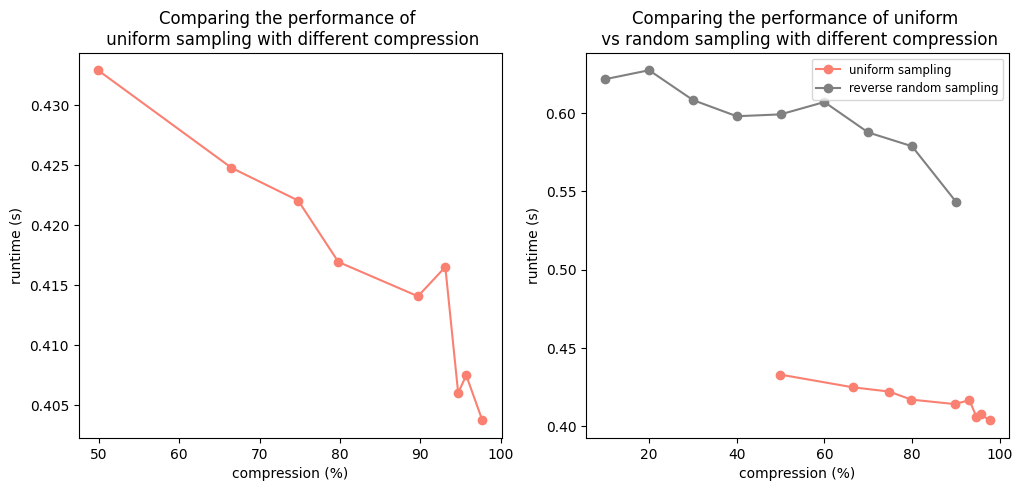

In [297]:
fig, axes = plt.subplots(1,2, figsize=(12, 5))
ax = axes[0]
ax.plot([100-round(compression,3)*100 for compression in compressions_uniform],runtimes_uniform, marker='o', color='salmon', label='uniform sampling')
ax.set_xlabel('compression (%)')
ax.set_ylabel('runtime (s)')
ax.set_title('Comparing the performance of \n uniform sampling with different compression')

ax = axes[1]
ax.plot([100-round(compression,3)*100 for compression in compressions_uniform],runtimes_uniform, marker='o', color='salmon', label='uniform sampling')
ax.plot([100-round(compression,3)*100 for compression in compressions],runtimes, marker='o', color='gray', label='random sampling')
ax.set_xlabel('compression (%)')
ax.set_ylabel('runtime (s)')
ax.set_title('Comparing the performance of uniform \n vs random sampling with different compression')
ax.legend(loc='upper right', fontsize='small')
plt.show()

Both random and uniform run faster with bigger compression, but (the implementation of) uniform sampling outperforms the random one significantly.

Error-wise, here is how uniform sampling compares to the original trajectories, as well as compared to random samping.

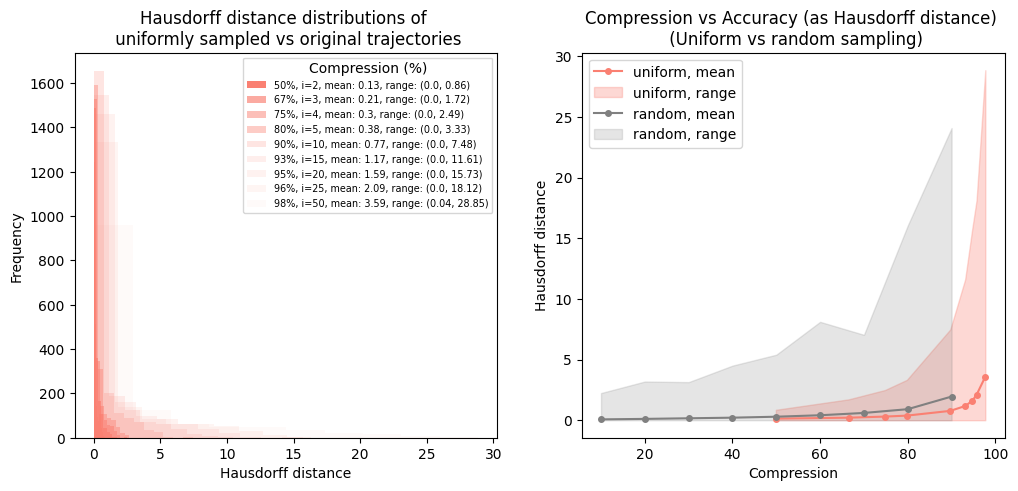

In [298]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Adjust the figsize as needed

mins_uniform = []
maxs_uniform = []
means_uniform = []

ax = axes[0]
for j, i in zip(errors_uniform, i_list):
    ax.hist(j,alpha=1/i*2,color='salmon',label=f'{round(100-100/i)}%, i={i}, mean: {round(sum(j)/len(j), 2)}, range: ({round(min(j),2)}, {round(max(j),2)})')

    mins_uniform.append(round(min(j),2))
    maxs_uniform.append(round(max(j),2))
    means_uniform.append(round(sum(j)/len(j), 2))

ax.set_ylabel('Frequency')
ax.set_xlabel('Hausdorff distance')
ax.legend(title='Compression (%)',fontsize='x-small')
ax.set_title('Hausdorff distance distributions of \n uniformly sampled vs original trajectories')

ax = axes[1]
x = [100-round(compression,3)*100 for compression in compressions_uniform]
x1 = [100-round(compression,3)*100 for compression in compressions]

ax.plot(x, means_uniform, marker='o',markersize=4, color='salmon', label='uniform, mean')
ax.fill_between(x, maxs_uniform, color = 'salmon', alpha=0.3, label='uniform, range')


ax.plot(x1, means, marker='o', markersize=4, color='gray', label='random, mean')
ax.fill_between(x1, maxs, color = 'gray', alpha=0.2, label='random, range')

ax.legend(loc='upper left')
ax.set_ylabel('Hausdorff distance')
ax.set_xlabel('Compression')
ax.set_title('Compression vs Accuracy (as Hausdorff distance) \n (Uniform vs random sampling)')

plt.show()

The plot above shows that uniform sampling outperforms random sampling even at greater compressions. To discuss what is a reasonable Hausdorff distance, a visual representation might be useful.

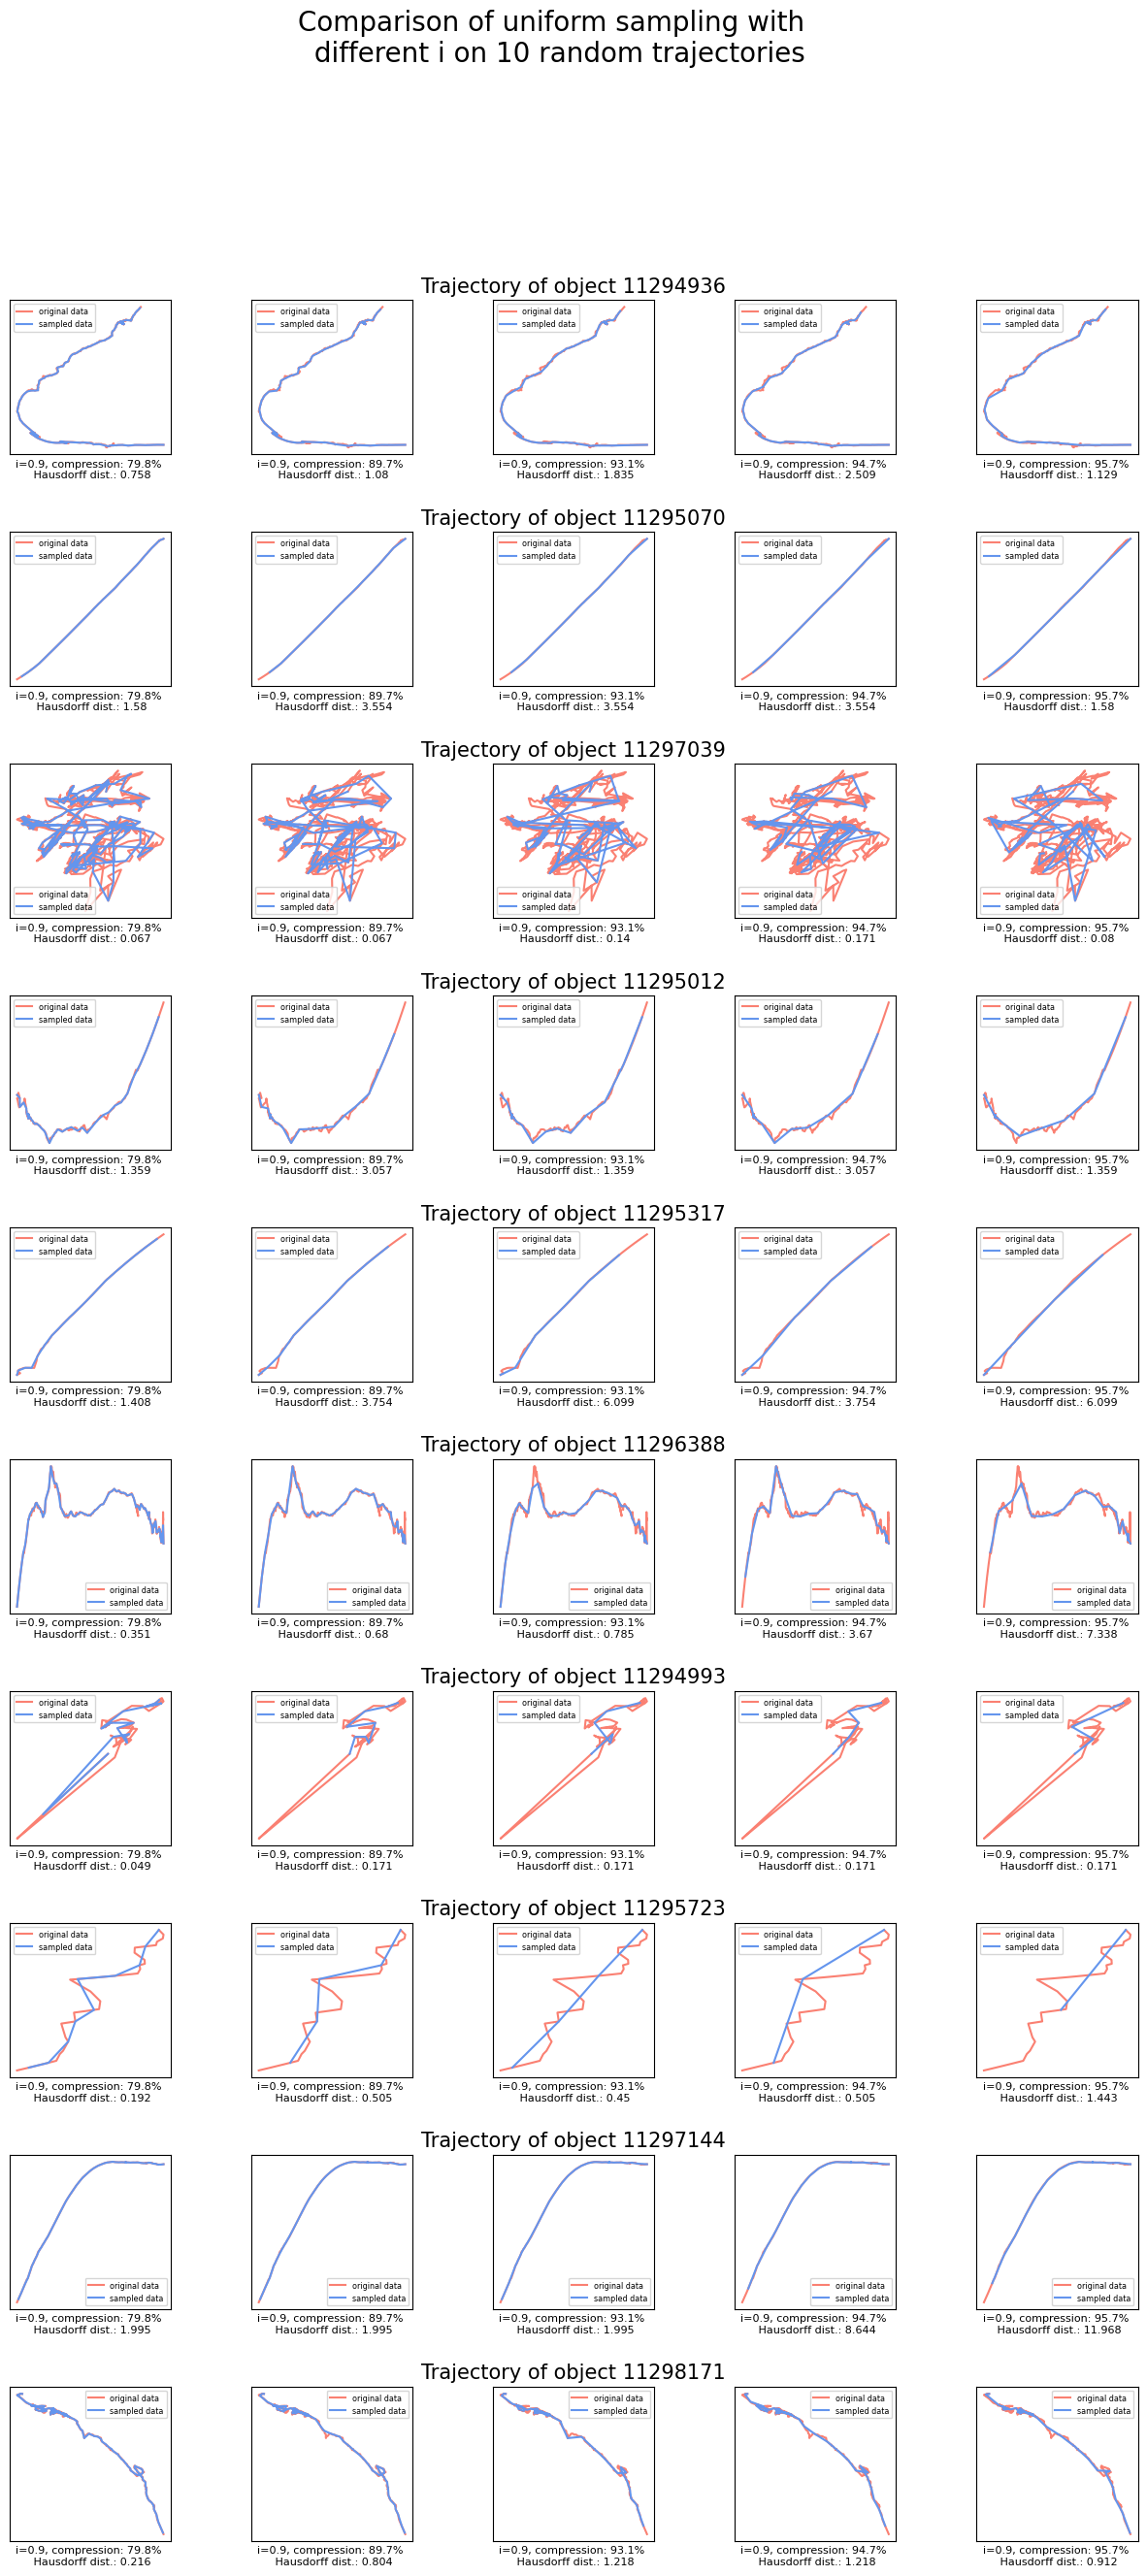

In [299]:
rows = 10
cols = 5
t_list = (uniform_sampled_df['object_id'].sample(n=rows, random_state=42).tolist())

fig, all_axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))

for t, j in zip(t_list, range(rows)):
    axes = all_axes[j]
    x, y = gdf.at[t, 'geometry'].xy

    for i, c in zip([5,10,15,20,25], range(cols)):
        uniform_sampled_df = df.groupby("object_id", group_keys=False).apply(uniform_sample,i=i)
        uniform_sampled_df = uniform_sampled_df.reset_index(drop=True)

        compression = uniform_sampled_df.memory_usage(deep=True).sum()/df.memory_usage(deep=True).sum()

        uniform_sampled_gdf = agl.add_geometry(uniform_sampled_df)

        x1, y1 = uniform_sampled_gdf.at[t, 'geometry'].xy
        h = shp.hausdorff_distance(uniform_sampled_gdf.at[t, 'geometry'], gdf.at[t, 'geometry'])
        ax = axes[c]
        ax.plot(x,y,color='salmon', label='original data')
        ax.plot(x1,y1,color='cornflowerblue',label='sampled data')
        ax.legend(loc='best',fontsize='xx-small')
        ax.set_yticks(())
        ax.set_xticks(())
        ax.text(0.5, -0.15, f'i={round(n,1)}, compression: {100-round(compression,3)*100}% \n Hausdorff dist.: {round(h,3)}', transform=ax.transAxes,
                horizontalalignment='center', fontsize=8, color='black')

    axes[2].set_title(f'Trajectory of object {t}', fontsize=15)    

plt.subplots_adjust(hspace=0.5, wspace=0.5) 

fig.suptitle(f'Comparison of uniform sampling with \n different i on {rows} random trajectories', fontsize=20)
plt.show()

### 2.3. Minimum displacement heuristic sampling

Applying a heuristic, then random sampling. First, the Euclidean distance between all consecutive is calculated. All points with distances above a certain threshold ε are preserved, the remainder are sampled randomly with probability 0.2. The compression rate in not constant.

The idea is to preserve points that are further away from their neighboring points, assuming they are more important to analyze the trajectory given their greater displacement. Still, to ensure computational efficiency, the remaining points are sampled randomly, as opposed to iteratively checking the distance between an anchor and the next point at a distance at least ε. This method is cheap and easy, but favors outliers (a possible pitfall) and is as reliable as random sampling.

Computationally, the runtimes are the same as (if not worse than) random sampling. There might be a better way to do this, using a proxy variable. Continue to next section.

#### 2.4. Speed heuristic sampling

The dataset contains a variable speed. As speed is a variable traditionally calculated based on displacement, we expect the two (speed and displacement) to have a strong correlation. If that is true, we can then use speed as a proxy for displacement and filter out the redundant datapoints based on it.

Given that the LiDAR collects data at a constant rate of 20 f/s, speed is often updated and a good variable to filter on. The logic is similar to the minimal displacement approach: the columns where the speed is below a certain threshold are dropped.

The problem arises if an object is moving at a speed below the threshold for a prolonged time (quite possible at an intersection). Then long segments of data are deleted, resulting in information loss.

The benefit of this approach is that there is no need to calculate displacement or perform filtering based on grouping (which gets slower as the number of groups goes up). The memory usage is also great, O(1).


First, however, we need to empirically assess the relationship between displacement and speed in this dataset.

In [7]:
# Calculate delta_dist in place
# NaN values replaced with 0s
def calc_displ(df):
    for _, group in df.groupby('object_id'):
        df.loc[group.index, 'delta_dist'] = np.sqrt(group['x'].diff()**2 + group['y'].diff()**2)
    
    df['delta_dist'] = df['delta_dist'].fillna(0)
    return df

In [5]:
def lin_regr(X: list, Y: list):
    x_ss = []
    y_ss = []
    ss = []
    x_mean = sum(X)/len(X)
    y_mean = sum(Y)/len(Y)
    for x, y in zip(X, Y):
        x_ss.append((x - x_mean)**2)
        y_ss.append(y - y_mean)
        ss.append((x - x_mean) * (y - y_mean))
    m = sum(ss)/sum(x_ss)
    b = y_mean - m * x_mean

    return m, b

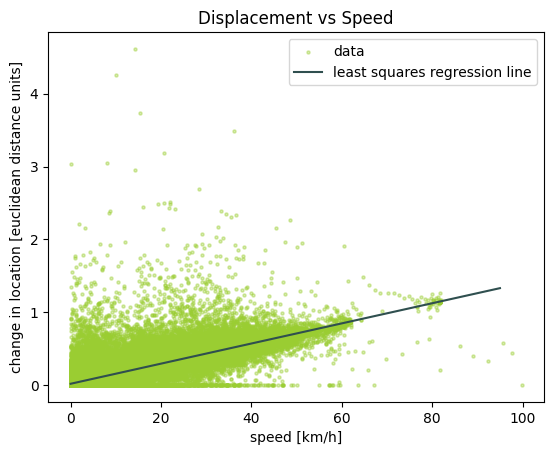

In [8]:
displ_df = calc_displ(df)
m, b = lin_regr(displ_df['speed_kmh'],displ_df['delta_dist'])

_, ax = plt.subplots()
ax.scatter(displ_df['speed_kmh'],displ_df['delta_dist'],color='yellowgreen', s=5, alpha=0.4, label='data')
ax.plot(np.arange(0,100,5),np.arange(0,100,5)*m+b,color = 'darkslategray',label='least squares regression line')
ax.set_ylabel('change in location [euclidean distance units]')
ax.set_xlabel('speed [km/h]')
ax.set_title('Displacement vs Speed')
ax.legend()
plt.show()


Visually, there is a strong correlation between displacement and speed. Let's quantify it.

In [9]:
import scipy.stats as sts

covariance = np.cov(displ_df['speed_kmh'], displ_df['delta_dist'])
corr, _ = sts.pearsonr(displ_df['speed_kmh'], displ_df['delta_dist'])

print('covariance matrix of speed and displacement: \n', covariance)
print('Pearsons correlation: %.3f' % corr)

covariance matrix of speed and displacement: 
 [[1.04544513e+02 1.44540898e+00]
 [1.44540898e+00 2.47312312e-02]]
Pearsons correlation: 0.899


Based on the covariance matrix:

- There is significant variability in speeds: the (X,X) value is ~104.5.
- Displacements have much less variability compared to speeds: (Y, Y) is just 0.025.

- There is a positive linear relationship between speeds and distances (the (X,Y) and (Y,X) value is 1.445) but this covariance is relatively small, potentially meaning this relationship is relatively weak.

To better understand this correlation, we calculate Pearson's r, which is 0.899. Simply put, 89.9% in one variable is explained by the other, signifying a close to perfect positive correlation.

Given the strength of the relationship, I believe speed can be used as a proxy for displacement without introducing too much error.

To figure out the speed threshold for dropping rows, let's calculate the quantiles corresponding to different compressions.

In [10]:
from tabulate import tabulate

table = [['compression %'],['speed threshold [km/h]'],['theoretical displacement* [m/frame**]'],['actual']]
for n in np.arange(0.1,1,0.1):
    threshold = displ_df['speed_kmh'].quantile(n)
    table[0].append(n*100)
    table[1].append(round(threshold, 4))
    table[2].append(round(threshold/3.6/1200, 4))
    table[3].append(np.mean(df[df['speed_kmh'] > threshold]['delta_dist']))

r_theoretical_vs_actual, _ = sts.pearsonr(table[3][1:],table[2][1:])    
print(tabulate(table[:3], tablefmt='fancy_grid'), f'\n*{round(r_theoretical_vs_actual,2)} correlation coefficient with means of actual displacements \n **1 frame = 1/20 s ')

╒═══════════════════════════════════════╤═══════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╕
│ compression %                         │ 10    │ 20      │ 30      │ 40      │ 50      │ 60      │ 70      │ 80      │ 90      │
├───────────────────────────────────────┼───────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ speed threshold [km/h]                │  0.07 │  0.23   │  0.87   │  2.86   │  4.06   │  4.74   │  5.35   │  6.82   │ 24.29   │
├───────────────────────────────────────┼───────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ theoretical displacement* [m/frame**] │  0    │  0.0001 │  0.0002 │  0.0007 │  0.0009 │  0.0011 │  0.0012 │  0.0016 │  0.0056 │
╘═══════════════════════════════════════╧═══════╧═════════╧═════════╧═════════╧═════════╧═════════╧═════════╧═════════╧═════════╛ 
*0.94 correlation coefficient with means of actual displacements 
 **1 frame = 1/20 s 


The correlation measure of 0.94 is just short of perfect. Therefore, it is reasonable to use speed as a proxy for displacement.

Here is how the speed heuristic reduction performs with real data:

In [11]:
errors_speed = []
runtimes_speed = []
compressions_speed = []

for n in list(np.arange(0.1,1,0.1))+list(np.arange(0.91,1,0.02)):
    # Runtime
    curr_runtimes = []
    for k in range(0,trials): # Running this multiple times in order to accurately estimate runtimes
        start = datetime.now()
        threshold = displ_df['speed_kmh'].quantile(n)
        speed_df = df[df['speed_kmh'] > threshold]
        end = datetime.now()
        curr_runtimes.append((end-start).total_seconds())
    runtimes_speed.append(sum(curr_runtimes)/len(curr_runtimes)) # Taking the mean
    
    # Errors
    speed_gdf = agl.add_geometry(speed_df)
    hausforff_dist_results = []
    for index in speed_gdf.index:
        original = gdf.at[index, 'geometry']
        sampled = speed_gdf.at[index, 'geometry']
        hausforff_dist_results.append(shp.hausdorff_distance(original,sampled,densify = 0.9))
    errors_speed.append(hausforff_dist_results)

    # Compression
    compressions_speed.append(speed_df.memory_usage(deep=True).sum()/df.memory_usage(deep=True).sum())

c:\Users\anape\Downloads\outsight\venv\Lib\site-packages\shapely\measurement.py:226: RuntimeWarning: invalid value encountered in hausdorff_distance_densify
  return lib.hausdorff_distance_densify(a, b, densify, **kwargs)
c:\Users\anape\Downloads\outsight\venv\Lib\site-packages\shapely\measurement.py:226: RuntimeWarning: invalid value encountered in hausdorff_distance_densify
  return lib.hausdorff_distance_densify(a, b, densify, **kwargs)
c:\Users\anape\Downloads\outsight\venv\Lib\site-packages\shapely\measurement.py:226: RuntimeWarning: invalid value encountered in hausdorff_distance_densify
  return lib.hausdorff_distance_densify(a, b, densify, **kwargs)
c:\Users\anape\Downloads\outsight\venv\Lib\site-packages\shapely\measurement.py:226: RuntimeWarning: invalid value encountered in hausdorff_distance_densify
  return lib.hausdorff_distance_densify(a, b, densify, **kwargs)
c:\Users\anape\Downloads\outsight\venv\Lib\site-packages\shapely\measurement.py:226: RuntimeWarning: invalid val

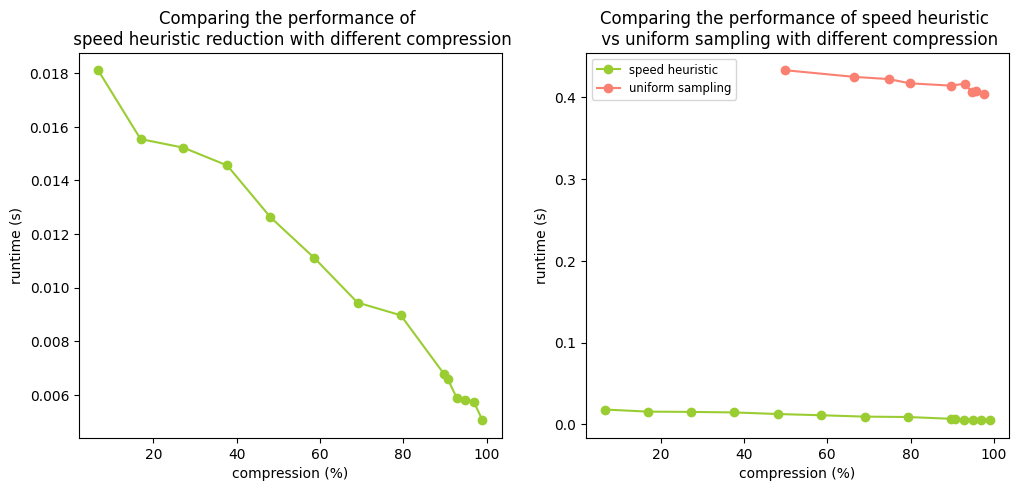

In [306]:
fig, axes = plt.subplots(1,2, figsize=(12, 5))
ax = axes[0]
ax.plot([100-round(compression,3)*100 for compression in compressions_speed],runtimes_speed, marker='o', color='yellowgreen', label='speed heuristic')
ax.set_xlabel('compression (%)')
ax.set_ylabel('runtime (s)')
ax.set_title('Comparing the performance of \n speed heuristic reduction with different compression')

ax = axes[1]
ax.plot([100-round(compression,3)*100 for compression in compressions_speed],runtimes_speed, marker='o', color='yellowgreen', label='speed heuristic')
ax.plot([100-round(compression,3)*100 for compression in compressions_uniform],runtimes_uniform, marker='o', color='salmon', label='uniform sampling')
ax.set_xlabel('compression (%)')
ax.set_ylabel('runtime (s)')
ax.set_title('Comparing the performance of speed heuristic \n vs uniform sampling with different compression')
ax.legend(loc='best', fontsize='small')
plt.show()

Runtime-wise, filtering on speed is extremely efficient as it is done at once rather than by group.

However, this also introduces errors as the average speed of different trajectories varies. As a result, the deleted rows are unevenly distributed. Slower objects' trajectories are reduced more than faster ones.

Looking at the histogram below, for the same compression rate, uniform sampling produces results that are substantially closer to the original trajectories. The range of uniform sampling is narrower than the very mean of speed heuristic filtering.

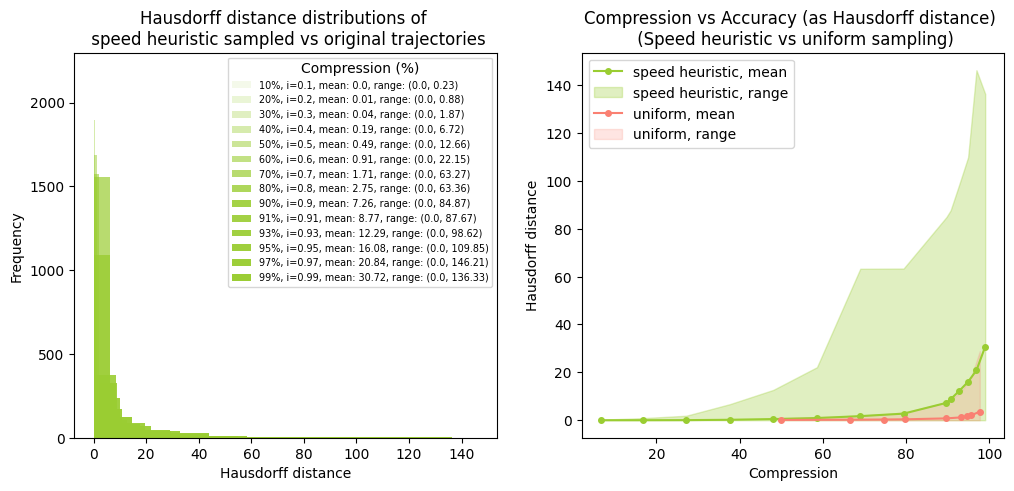

In [307]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Adjust the figsize as needed

mins_speed = []
maxs_speed = []
means_speed = []

ax = axes[0]
for j, i in zip(errors_speed, list(np.arange(0.1,1,0.1))+list(np.arange(0.91,1,0.02))):
    ax.hist(j,alpha=i,color='yellowgreen',label=f'{round(i*100)}%, i={round(i,2)}, mean: {round(sum(j)/len(j), 2)}, range: ({round(min(j),2)}, {round(max(j),2)})')

    mins_speed.append(round(min(j),2))
    maxs_speed.append(round(max(j),2))
    means_speed.append(round(sum(j)/len(j), 2))

ax.set_ylabel('Frequency')
ax.set_xlabel('Hausdorff distance')
ax.legend(title='Compression (%)',fontsize='x-small')
ax.set_title('Hausdorff distance distributions of \n speed heuristic sampled vs original trajectories')

ax = axes[1]
x = [100-round(compression,3)*100 for compression in compressions_speed]
x1 = [100-round(compression,3)*100 for compression in compressions_uniform]

ax.plot(x, means_speed, marker='o',markersize=4, color='yellowgreen', label='speed heuristic, mean')
ax.fill_between(x, maxs_speed, color = 'yellowgreen', alpha=0.3, label='speed heuristic, range')


ax.plot(x1, means_uniform, marker='o', markersize=4, color='salmon', label='uniform, mean')
ax.fill_between(x1, maxs_uniform, color = 'salmon', alpha=0.2, label='uniform, range')

ax.legend(loc='upper left')
ax.set_ylabel('Hausdorff distance')
ax.set_xlabel('Compression')
ax.set_title('Compression vs Accuracy (as Hausdorff distance) \n (Speed heuristic vs uniform sampling)')

plt.show()

However, the speed heuristic is very efficient computationally, so it is worth exploring it further.

Below, we split the dataset in two based on speed and compare errors.

In [51]:
mean_speed = df['speed_kmh'].mean()

fast_objects = df[df['speed_kmh'] > mean_speed]['object_id'].unique()

fast_df = df['object_id'].isin(fast_objects)
slow_df = ~df['object_id'].isin(fast_objects)


In [52]:
errors_fastspeed = []
compressions_fastspeed = []

errors_slowspeed = []
compressions_slowspeed = []

for n in list(np.arange(0.1,1,0.1))+list(np.arange(0.91,1,0.02)):
    # Runtime

    threshold = df['speed_kmh'].quantile(n)
    fast_speed_df = df[fast_df][df[fast_df]['speed_kmh'] > threshold]
    slow_speed_df = df[slow_df][df[slow_df]['speed_kmh'] > threshold]


    
    # Errors
    fast_speed_gdf = agl.add_geometry(fast_speed_df)
    slow_speed_gdf = agl.add_geometry(slow_speed_df)
    hausforff_dist_results = []
    for index in fast_speed_gdf.index:
        original = gdf.at[index, 'geometry']
        sampled = fast_speed_gdf.at[index, 'geometry']
        hausforff_dist_results.append(shp.hausdorff_distance(original,sampled,densify = 0.9))
    errors_fastspeed.append(hausforff_dist_results)

    hausforff_dist_results = []
    for index in slow_speed_gdf.index:
        original = gdf.at[index, 'geometry']
        sampled = slow_speed_gdf.at[index, 'geometry']
        hausforff_dist_results.append(shp.hausdorff_distance(original,sampled,densify = 0.9))
    errors_slowspeed.append(hausforff_dist_results)

    # Compression
    compressions_fastspeed.append(fast_speed_df.memory_usage(deep=True).sum()/df.memory_usage(deep=True).sum())
    compressions_slowspeed.append(slow_speed_df.memory_usage(deep=True).sum()/df.memory_usage(deep=True).sum())

c:\Users\anape\Downloads\outsight\venv\Lib\site-packages\shapely\measurement.py:226: RuntimeWarning: invalid value encountered in hausdorff_distance_densify
  return lib.hausdorff_distance_densify(a, b, densify, **kwargs)
c:\Users\anape\Downloads\outsight\venv\Lib\site-packages\shapely\measurement.py:226: RuntimeWarning: invalid value encountered in hausdorff_distance_densify
  return lib.hausdorff_distance_densify(a, b, densify, **kwargs)
c:\Users\anape\Downloads\outsight\venv\Lib\site-packages\shapely\measurement.py:226: RuntimeWarning: invalid value encountered in hausdorff_distance_densify
  return lib.hausdorff_distance_densify(a, b, densify, **kwargs)
c:\Users\anape\Downloads\outsight\venv\Lib\site-packages\shapely\measurement.py:226: RuntimeWarning: invalid value encountered in hausdorff_distance_densify
  return lib.hausdorff_distance_densify(a, b, densify, **kwargs)
c:\Users\anape\Downloads\outsight\venv\Lib\site-packages\shapely\measurement.py:226: RuntimeWarning: invalid val

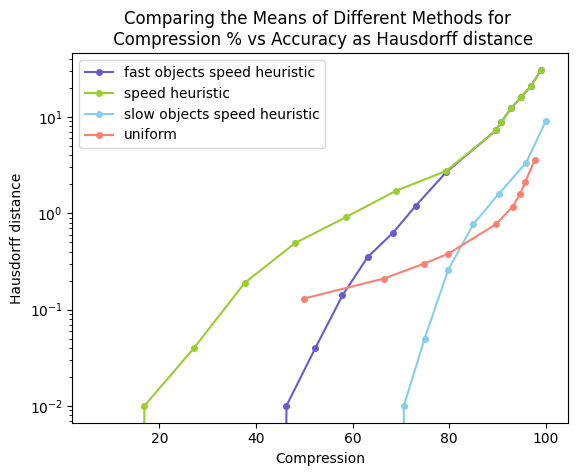

In [69]:
fig, ax = plt.subplots()  # Adjust the figsize as needed

mins_fastspeed = []
maxs_fastspeed = []
means_fastspeed = []

for j, i in zip(errors_fastspeed, list(np.arange(0.1,1,0.1))+list(np.arange(0.91,1,0.02))):
    mins_fastspeed.append(round(min(j),2))
    maxs_fastspeed.append(round(max(j),2))
    means_fastspeed.append(round(sum(j)/len(j), 2))

mins_slowspeed = []
maxs_slowspeed = []
means_slowspeed = []

for j, i in zip(errors_slowspeed, list(np.arange(0.1,1,0.1))+list(np.arange(0.91,1,0.02))):
    if len(j)>0:
        mins_slowspeed.append(round(min(j),2))
        maxs_slowspeed.append(round(max(j),2))
        means_slowspeed.append(round(sum(j)/len(j), 2))

x = [100-round(compression,3)*100 for compression in compressions_speed]
x1 = [100-round(compression,3)*100 for compression in compressions_uniform]
x2 = [100-round(compression,3)*100 for compression in compressions_fastspeed]
x3 = [100-round(compression,3)*100 for compression in compressions_slowspeed if compression != 0]

ax.plot(x2, means_fastspeed, marker='o', markersize=4, color='slateblue', label='fast objects speed heuristic')
# ax.fill_between(x2, maxs_fastspeed, color = 'slaterblue', alpha=0.2, label='fast, range')

ax.plot(x, means_speed, marker='o',markersize=4, color='yellowgreen', label='speed heuristic')
# ax.fill_between(x, maxs_speed, color = 'yellowgreen', alpha=0.3, label='speed heuristic, range')

ax.plot(x3, means_slowspeed, marker='o', markersize=4, color='skyblue', label='slow objects speed heuristic')
# ax.fill_between(x2, maxs_fastspeed, color = 'slaterblue', alpha=0.2, label='fast, range')

ax.plot(x1, means_uniform, marker='o', markersize=4, color='salmon', label='uniform')
# ax.fill_between(x1, maxs_uniform, color = 'salmon', alpha=0.2, label='uniform, range')

ax.set_yscale('log')
ax.legend(loc='upper left')
ax.set_ylabel('Hausdorff distance')
ax.set_xlabel('Compression')
ax.set_title('Comparing the Means of Different Methods for \n Compression % vs Accuracy as Hausdorff distance')

plt.show()
